In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

from src_python.utils import mut_count_distance

base_path = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data"

n_cells_list = [500]
n_mut_list = [100]
n_clones_list = [""] #[5, 10, 20, ""]

n_samples = 5
n_rounds = 3

all_vaf_errors = []

all_overdispersions_gt = []
all_overdispersions = []

all_dropout_probs_gt = []
all_dropout_probs = []

all_mut_prob_distances = []

all_global_parameters = []

for clone in n_clones_list:
    for (n_cells, n_mut) in zip(n_cells_list, n_mut_list):
        path_gt = os.path.join(base_path,  f"{n_cells}c{n_mut}m{clone}")
        path = os.path.join(base_path, f"{n_cells}c{n_mut}m{clone}", "sciterna")
        print(path)

        sample_vaf_errors = []
        for i in range(n_samples):
            genotype = np.loadtxt(os.path.join(path_gt, "genotype", f"genotype_{i}.txt"), dtype=str)
            alt = np.loadtxt(os.path.join(path_gt, "alt", f"alt_{i}.txt"), dtype=int)
            ref = np.loadtxt(os.path.join(path_gt, "ref", f"ref_{i}.txt"), dtype=int)
            vaf = alt/(ref+alt)
            overdispersions_h = np.loadtxt(os.path.join(path_gt, "overdispersions_H", f"overdispersions_H_{i}.txt"))
            dropout_probs = np.loadtxt(os.path.join(path_gt, "dropout_probs", f"dropout_probs_{i}.txt"))

            indices = np.where(np.sum(genotype=="H", axis=0) >= 450) # only loci with enough heterozygous cells

            mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
            vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
            genotype_gt = vectorized_map(genotype)

            round_vaf_errors = []
            round_mut_prob_distances = []
            for r in range(n_rounds):
                sciterna_individual_dropout_probs = np.loadtxt(os.path.join(path, f"sciterna_individual_dropout_probs/sciterna_individual_dropout_probs_{r}r{i}.txt")).T
                sciterna_individual_overdispersions_h = np.loadtxt(os.path.join(path, f"sciterna_individual_overdispersions_H/sciterna_individual_overdispersions_H_{r}r{i}.txt"))
                sciterna_global_parameters = np.loadtxt(os.path.join(path, f"sciterna_global_parameters/sciterna_global_parameters_{r}r{i}.txt"))
                sciterna_genotype = np.loadtxt(os.path.join(path, f"sciterna_genotype/sciterna_genotype_{r}r{i}.txt"), dtype=str)
                genotype_predicted = vectorized_map(sciterna_genotype)
                sciterna_global_parameters = np.loadtxt(os.path.join(path, f"sciterna_global_parameters/sciterna_global_parameters_{r}r{i}.txt"))

                differences_genotype = np.where(genotype != sciterna_genotype, 1, 0)
                vaf_error = np.sum(differences_genotype)/(n_cells*n_mut)
                round_vaf_errors.append(vaf_error)

                all_overdispersions.extend(sciterna_individual_overdispersions_h[indices])
                all_overdispersions_gt.extend(overdispersions_h[indices])

                # if any(overdispersions_h[indices] > 20):
                #     for ind in indices[0]:
                #         if overdispersions_h[ind] > 20:
                #             vafs_reduced = vaf[:, ind]
                #             genotype_reduced = genotype[:, ind]
                #             relevant_vafs = []
                #             for i in range(n_cells):
                #                 if genotype_reduced[i] == "H":
                #                     relevant_vafs.append(vafs_reduced[i])
                #
                #             plt.title(str(sciterna_individual_overdispersions_h[ind]) + " " + str(overdispersions_h[ind]))
                #             plt.hist(relevant_vafs)
                #             plt.show()

                all_dropout_probs.extend(sciterna_individual_dropout_probs[indices])
                all_dropout_probs_gt.extend(dropout_probs[indices])
                round_mut_prob_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

                all_global_parameters.append(sciterna_global_parameters)
            sample_vaf_errors.append(round_vaf_errors)
            all_mut_prob_distances.append(round_mut_prob_distances)
        all_vaf_errors.append(sample_vaf_errors)

C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data\500c100m\sciterna


C:\Users\Norio\AppData\Local\Temp\ipykernel_15976\1926085776.py:39: RuntimeWarning: invalid value encountered in divide
  vaf = alt/(ref+alt)


In [18]:
print(np.mean(np.array(all_mut_prob_distances), axis=(0)))
print(np.mean(np.array(all_vaf_errors), axis=(0,1)))
print(np.mean(np.array(all_global_parameters), axis=(0)))

[2.65031663 2.56058517 2.55991182]
[0.020476 0.020084 0.02014 ]
[ 0.1881052   0.47555927 11.17425333  0.04677071  5.97506   ]


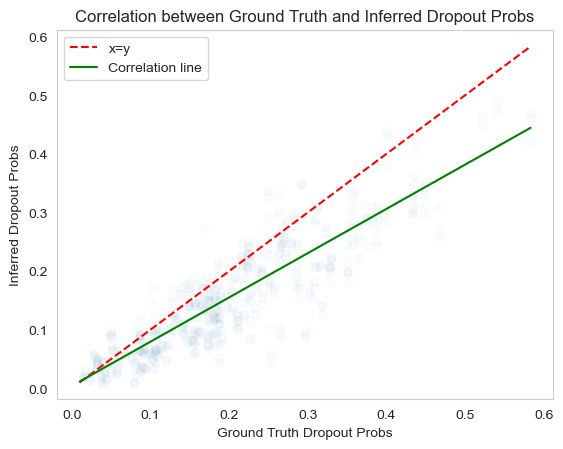

In [17]:
x = np.array(all_dropout_probs_gt)
y = np.array(all_dropout_probs)

plt.scatter(x, y, alpha=0.02)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Dropout Probs")
plt.ylabel("Inferred Dropout Probs")
plt.title("Correlation between Ground Truth and Inferred Dropout Probs")
plt.legend()
plt.show()

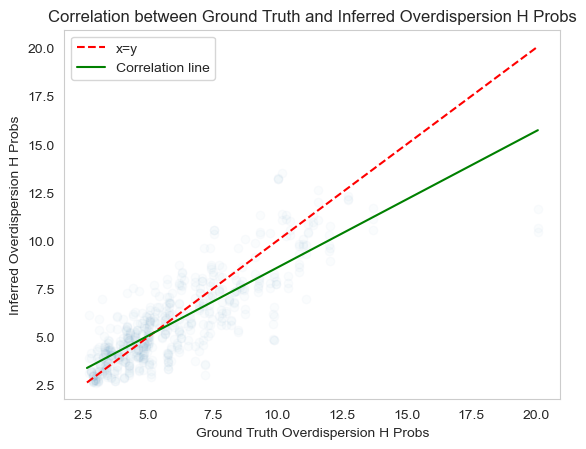

In [19]:
import matplotlib.pyplot as plt

x = np.array(all_overdispersions_gt)
y = np.array(all_overdispersions)
indices = np.where(y != 6)
y = y[indices]
x = x[indices]

plt.scatter(x, y, alpha=0.02)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Overdispersion H Probs")
plt.ylabel("Inferred Overdispersion H Probs")
plt.title("Correlation between Ground Truth and Inferred Overdispersion H Probs")
plt.legend()
plt.show()

In [5]:
# compare C++ and Python results
import matplotlib.pyplot as plt
import numpy as np
import os

c_dir = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data_c"
python_dir = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data"
n_tests = 100
n_rounds = 3

n_cells_list = [50, 100, 100]
n_muts_list = [100, 50, 100]
n_clones_list = [5, 10, 20, ""]

for n_cells, n_mut in zip(n_cells_list, n_muts_list):
    for clone in n_clones_list:
        for test in range(n_tests):
            for r in range(n_rounds):
                c_selected = np.loadtxt(os.path.join(c_dir, f"{n_cells}c{n_mut}m{clone}", "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{r}r{test}.txt"))
                python_selected = np.loadtxt(os.path.join(python_dir, f"{n_cells}c{n_mut}m{clone}", "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{r}r{test}.txt"))

                if not np.array_equal(c_selected, python_selected):
                    print(r, test, n_cells, n_mut, clone)

0 0 50 100 10
1 0 50 100 10
2 0 50 100 10
0 1 50 100 10
1 1 50 100 10
2 1 50 100 10
0 2 50 100 10
1 2 50 100 10
2 2 50 100 10
0 3 50 100 10
1 3 50 100 10
2 3 50 100 10
0 4 50 100 10
1 4 50 100 10
2 4 50 100 10
0 5 50 100 10
1 5 50 100 10
2 5 50 100 10
0 6 50 100 10
1 6 50 100 10
2 6 50 100 10
0 7 50 100 10
1 7 50 100 10
2 7 50 100 10
0 8 50 100 10
1 8 50 100 10
2 8 50 100 10
0 9 50 100 10
1 9 50 100 10
2 9 50 100 10
0 10 50 100 10
1 10 50 100 10
2 10 50 100 10
0 11 50 100 10
1 11 50 100 10
2 11 50 100 10
0 12 50 100 10
1 12 50 100 10
2 12 50 100 10
0 13 50 100 10
1 13 50 100 10
2 13 50 100 10
0 14 50 100 10
1 14 50 100 10
2 14 50 100 10
0 15 50 100 10
1 15 50 100 10
2 15 50 100 10
0 16 50 100 10
1 16 50 100 10
2 16 50 100 10
0 17 50 100 10
1 17 50 100 10
2 17 50 100 10
0 18 50 100 10
1 18 50 100 10
2 18 50 100 10
0 19 50 100 10
1 19 50 100 10
2 19 50 100 10
0 20 50 100 10
1 20 50 100 10
2 20 50 100 10
0 21 50 100 10
1 21 50 100 10
2 21 50 100 10
0 22 50 100 10
1 22 50 100 10
2 22 50 10